### Importing libraries and data

In [4]:
# Import libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [5]:
quandl.ApiConfig.api_key = 'Vys_D6tG4cCwMGo7yXpu'

In [26]:
# Importing the Federal Reserve Economic Data "Real Potential Gross Domestic Product" variable.

data = quandl.get('FRED/GDPPOT')

In [27]:
data.head(5)

,Value
Date,
1949-01-01,2102.982630
1949-04-01,2130.581305
1949-07-01,2159.340530
1949-10-01,2186.844859
1950-01-01,2216.058359


In [8]:
data.shape

(332, 1)

In [9]:
data.columns

Index(['Value'], dtype='object')

In [10]:
type(data)

pandas.core.frame.DataFrame

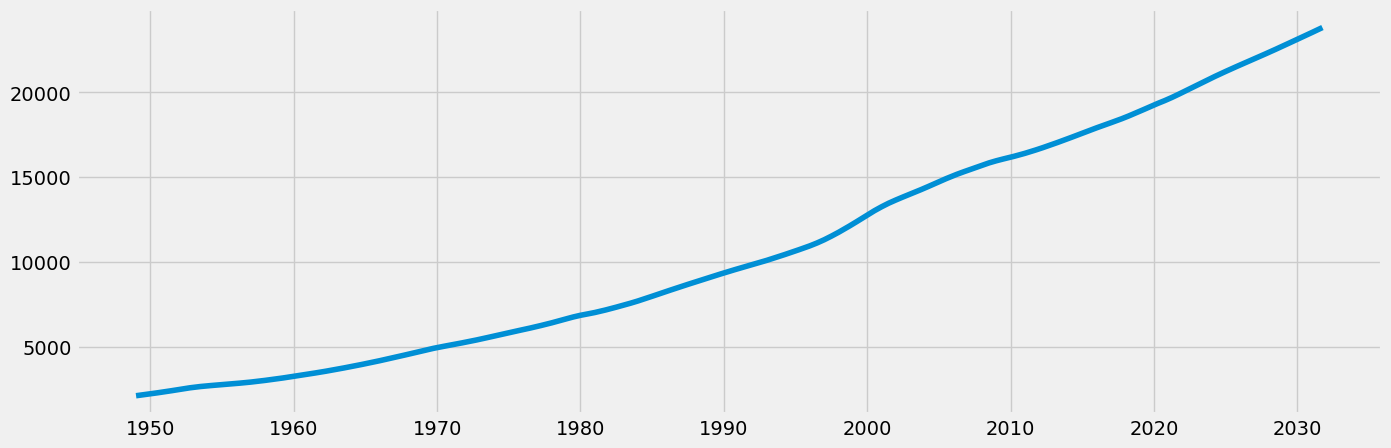

In [11]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### Subsetting, Wrangling, and Cleaning Time Series Data

In [12]:
data_2 = data.reset_index()

In [13]:
data_2.head(5)

,Date,Value
0,1949-01-01,2102.982630
1,1949-04-01,2130.581305
2,1949-07-01,2159.340530
3,1949-10-01,2186.844859
4,1950-01-01,2216.058359


In [14]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [15]:
data_sub.shape

(162, 2)

In [16]:
data_sub.head()

,Date,Value
124,1980-01-01,6847.481683
125,1980-04-01,6890.146039
126,1980-07-01,6928.061362
127,1980-10-01,6968.010712
128,1981-01-01,7012.104757


In [17]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6847.481683
1980-04-01,6890.146039
1980-07-01,6928.061362
1980-10-01,6968.010712
1981-01-01,7012.104757


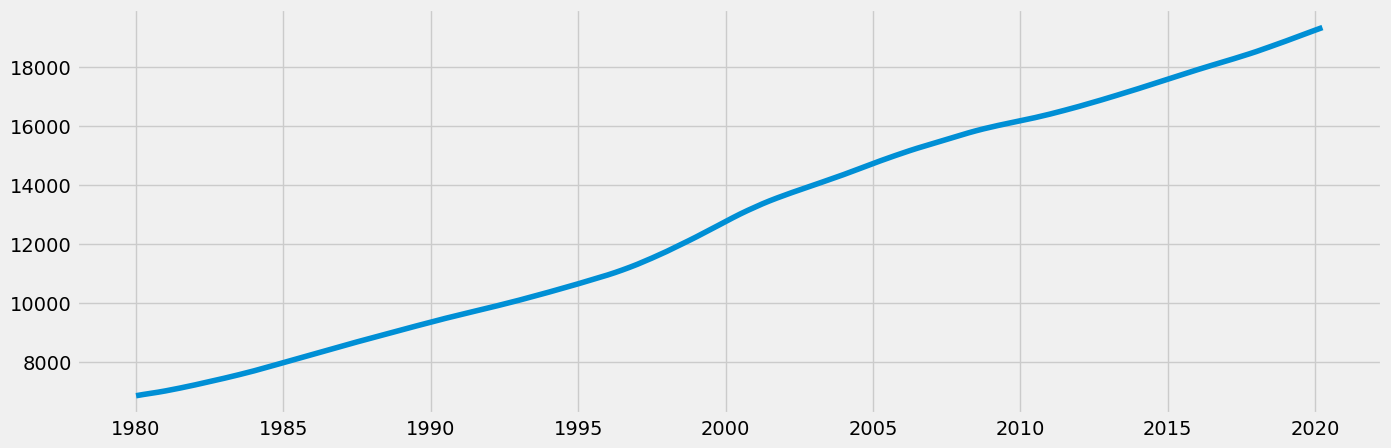

In [18]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [19]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [20]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

### Time Series Analysis

In [21]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [22]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

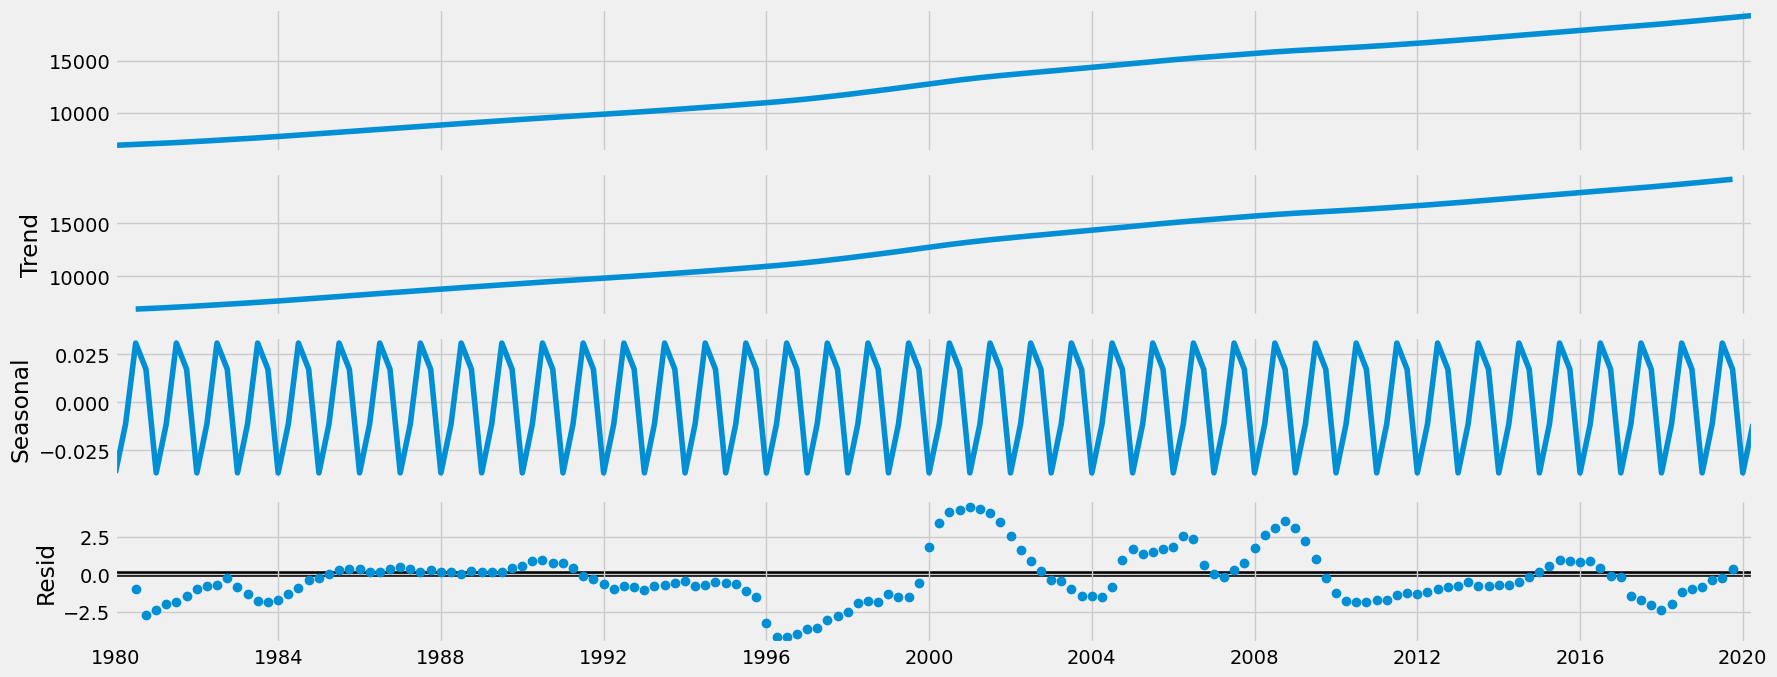

In [23]:
# Plot the separate components

decomposition.plot()
plt.show()

Observations:
- From the grafic plot we can see that there is a trend of increasing real GDP over the years. Surprisingly, the rend doesn't change, neither shows fall back even during the 2008 economic crisis. Based on this later fact, I would be interested in examining the nominal GDP data, but even more the per capita GDP data (nominal and real).

### Checking for stationarity

In [24]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.137050
p-value                          0.945621
Number of Lags Used              5.000000
Number of Observations Used    156.000000
Critical Value (1%)             -3.472979
Critical Value (5%)             -2.880252
Critical Value (10%)            -2.576747
dtype: float64


**Observations:** The Dickey-Fuller test that we condacted shows that this time series are non - stationari.
The Critical Value (10%) is -2.576747, which is biger than the Statistic Test of  -0.137050.
Aslo the p - value of 0.945621, indicated that the test result is not significant.

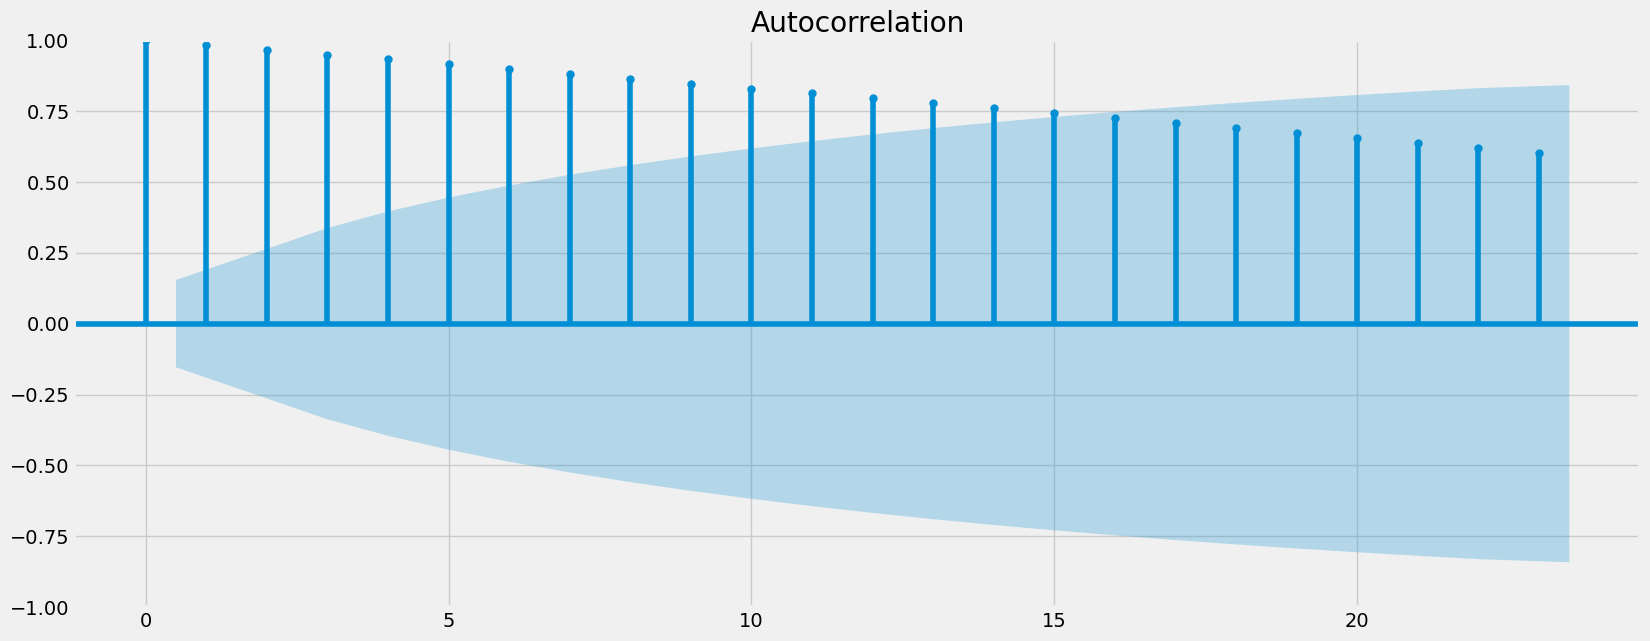

In [25]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

**Observations:**
The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means the lags are significantly correlated with each other. We have many lags beyond this interval, and can deduce that this data is non-stationary.

### Stationarizing the Federal Reserve Economic Data

In [28]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [29]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [30]:
data_diff.head()

,Value
datetime,
1980-04-01,42.664356
1980-07-01,37.915323
1980-10-01,39.949350
1981-01-01,44.094045
1981-04-01,47.180044


In [31]:
data_diff.columns

Index(['Value'], dtype='object')

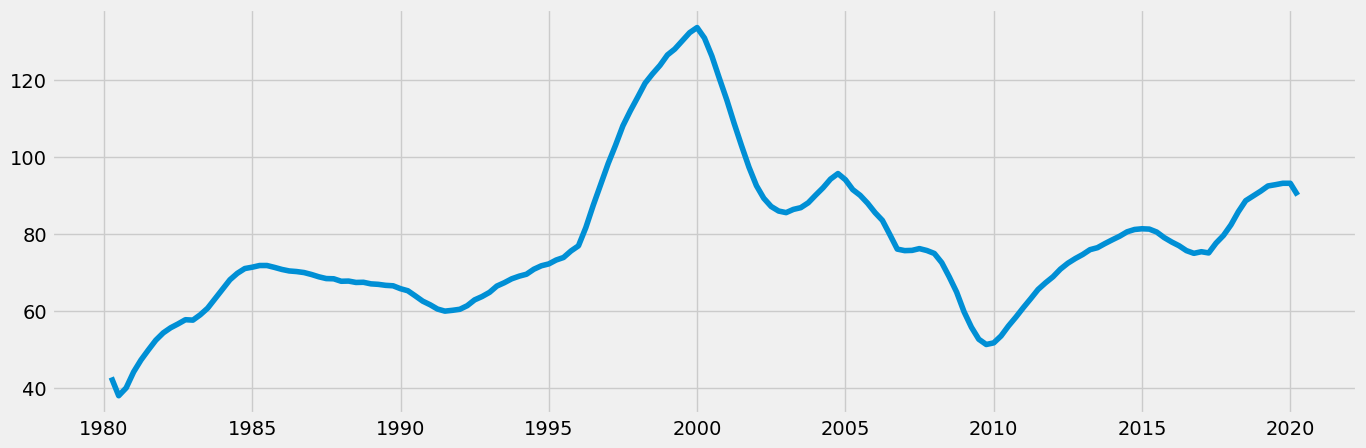

In [32]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [33]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.242815
p-value                          0.191075
Number of Lags Used              4.000000
Number of Observations Used    156.000000
Critical Value (1%)             -3.472979
Critical Value (5%)             -2.880252
Critical Value (10%)            -2.576747
dtype: float64


**Observations:**
After Stationarizing the real GDP time series data using the Differencing method we found that test statistic is now smaller than the critical value at both the five and ten percent significance levels. This means we can reject the null hypothesis and, as a result, consider real GDP data series stationary. The p-value is still too high (p>0.05) therefore the result is not significant.

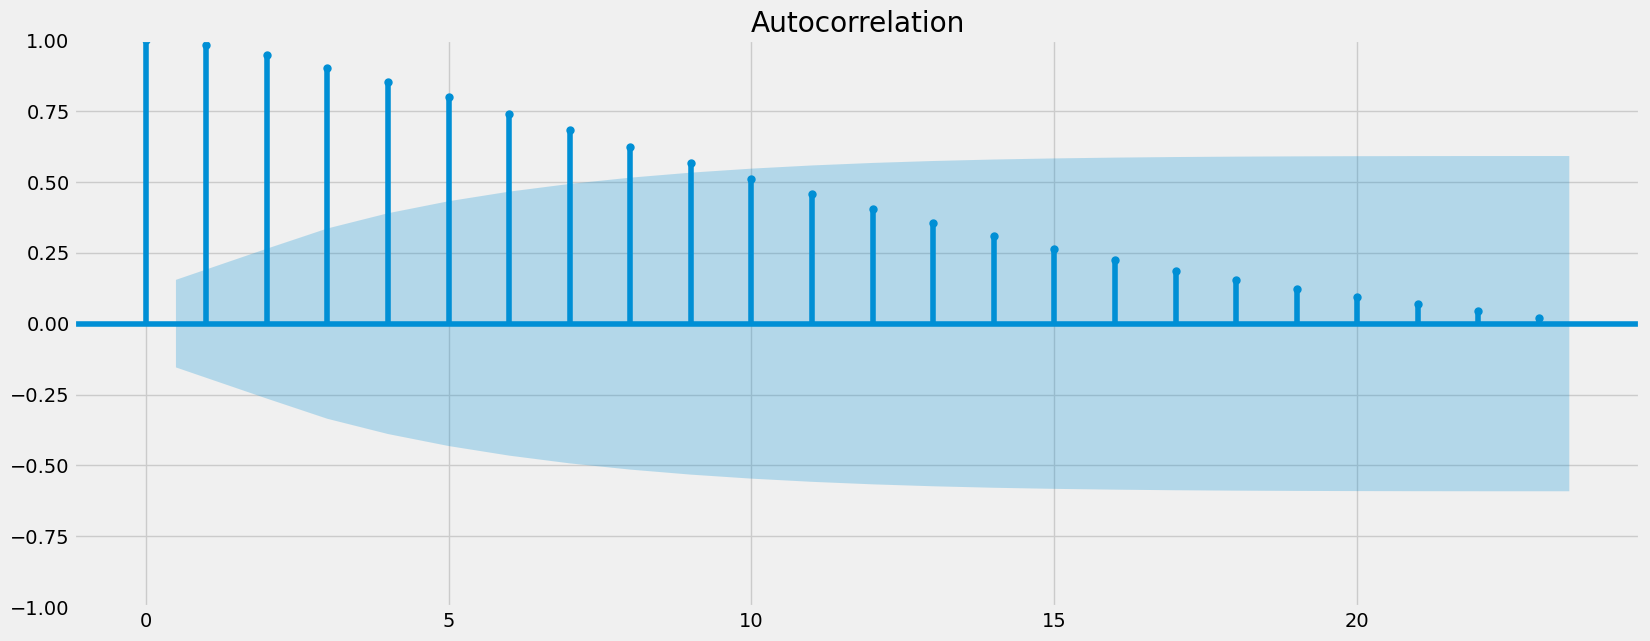

In [34]:
plot_acf(data_diff)
plt.show()

**Observations:**
While the autocorrelation plot has improved a bit (there are fewer autocorrelated terms), it’s still not perfect. This means that, despite the Dickey-Fuller test saying that data is stationary, that stationarity is weak.